<a href="https://colab.research.google.com/github/Deba951/Hyperspectral_Image_Analysis_Learning/blob/main/Auto_Encoders_for_Land_Cover_Classification_in_Hyperspectral_Images_Part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install earthpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 62.6 MB/s eta 0:00:00


In [2]:
import matplotlib.pyplot as plt

import numpy as np
import earthpy.plot as ep
import seaborn as sns
import earthpy.spatial as es

import plotly.graph_objects as go
import plotly.express as px

from scipy.io import loadmat

import pandas as pd
import io

from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score,
                             confusion_matrix, classification_report)

In [4]:
# %cd drive/MyDrive
# from google.colab import files
# uploaded = files.upload()

In [5]:
ae_df = pd.read_csv('AE_PU_data.csv', index_col=0)
ae_df.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,class
feature_0,,,,,,,,,,,,,,,,,,,,,
0.544151,0.232160,0.069741,0.067038,0.112935,0.394583,0.060980,0.145349,0.573995,0.391644,0.019086,...,-0.030734,0.436527,0.094691,0.227523,0.128186,-0.039043,0.011000,-0.081880,-0.222694,0
0.570209,0.192820,0.095218,0.123708,0.088946,0.442346,0.128459,0.067774,0.608239,0.311190,0.042016,...,-0.041752,0.423109,0.137206,0.196235,0.110357,-0.101144,0.017677,-0.159596,-0.263916,0
0.658676,0.255207,0.175070,0.153119,0.101674,0.483959,0.173528,0.066707,0.669932,0.253983,0.051251,...,-0.112228,0.423917,0.199818,0.149335,0.055112,-0.131243,0.020270,-0.191052,-0.339840,0
0.615194,0.231976,0.123209,0.123457,0.072496,0.471360,0.135576,0.109428,0.636488,0.302270,0.048110,...,-0.082369,0.396278,0.118449,0.180039,0.083205,-0.113680,0.066215,-0.169278,-0.299894,0
0.586622,0.181849,0.112774,0.133507,0.055689,0.448270,0.157168,0.058972,0.607651,0.241390,0.044559,...,-0.056397,0.359391,0.125627,0.150722,0.090379,-0.125672,0.076915,-0.208369,-0.282966,0


In [6]:
# Removing pixels which has label as 0.

res_df = ae_df[ae_df['class'] != 0]
res_df.shape

(42776, 60)

In [7]:
X = res_df.iloc[:, :-1].values
y = res_df.iloc[:, -1].values

X.shape, y.shape

((42776, 59), (42776,))

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.70, stratify = y.ravel())
print(f"X_train Shape: {X_train.shape}\nX_test Shape: {X_test.shape}\ny_train Shape: {y_train.shape}\ny_test Shape:{y_test.shape}")

X_train Shape: (12832, 59)
X_test Shape: (29944, 59)
y_train Shape: (12832,)
y_test Shape:(29944,)


### KNNC

In [9]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 10)

knn.fit(X_train, y_train)

knn_pred = knn.predict(X_test)

In [10]:
print(f"Accuracy: {accuracy_score(y_test, knn_pred)*100}\n")
print(classification_report(y_test, knn_pred))

Accuracy: 86.22762489981298

              precision    recall  f1-score   support

           1       0.92      0.88      0.90      4642
           2       0.86      0.97      0.91     13055
           3       0.66      0.71      0.68      1469
           4       0.96      0.84      0.89      2145
           5       1.00      0.99      0.99       942
           6       0.83      0.51      0.63      3520
           7       0.79      0.79      0.79       931
           8       0.80      0.81      0.81      2577
           9       1.00      1.00      1.00       663

    accuracy                           0.86     29944
   macro avg       0.87      0.83      0.85     29944
weighted avg       0.86      0.86      0.86     29944



In [13]:
from tqdm.notebook import tqdm

def predict_class(df, cls, name=None):
  if name!='lgb':
    pred = [0 if df.iloc[i, :][-1] == 0 else cls.predict(df.iloc[i, :][:-1].values.reshape(1,-1))[0]
          for i in tqdm(range(df.shape[0]))]
  else:
    pred = [0 if df.iloc[i, :][-1] == 0 else np.argmax(cls.predict(df.iloc[i, :][:-1].values.reshape(1,-1)), axis=1)[0]
          for i in tqdm(range(df.shape[0]))]
  return np.array(pred)


In [12]:
pred = predict_class(ae_df, knn)


  0%|          | 0/207400 [00:00<?, ?it/s]

97.26470588235294


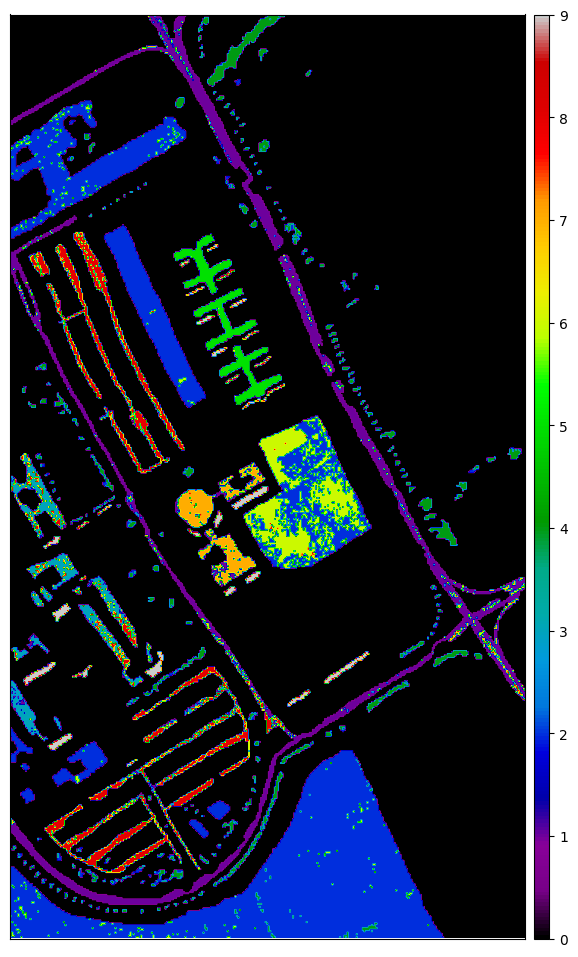

In [14]:
print(accuracy_score(ae_df['class'].values, pred)*100)
ep.plot_bands(pred.reshape((610, 340)), cmap='nipy_spectral')
plt.show()

In [15]:
from sklearn.svm import SVC

svm = SVC(C = 5.0, kernel = 'rbf', cache_size = 4*1024)

# Fit Data
svm.fit(X_train, y_train)

# Predict labels for test data
svm_pred = svm.predict(X_test)

# Accuracy and Classification Reeport
print(f"Accuracy: {accuracy_score(y_test, svm_pred)*100}")
print(classification_report(y_test, svm_pred))

Accuracy: 83.54595244456318
              precision    recall  f1-score   support

           1       0.83      0.90      0.87      4642
           2       0.83      0.98      0.90     13055
           3       0.64      0.46      0.53      1469
           4       0.93      0.87      0.90      2145
           5       1.00      0.99      0.99       942
           6       0.91      0.35      0.50      3520
           7       0.78      0.39      0.52       931
           8       0.75      0.87      0.81      2577
           9       1.00      1.00      1.00       663

    accuracy                           0.84     29944
   macro avg       0.85      0.76      0.78     29944
weighted avg       0.84      0.84      0.82     29944



  0%|          | 0/207400 [00:00<?, ?it/s]

96.61957569913211


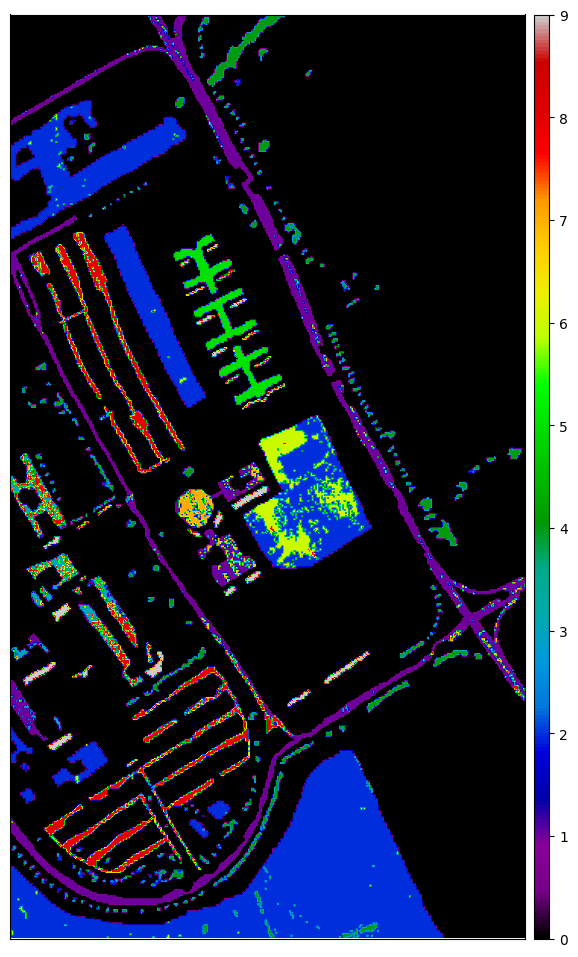

In [16]:
svm_preds = predict_class(ae_df, svm)
print(accuracy_score(ae_df['class'].values, svm_preds)*100)
ep.plot_bands(svm_preds.reshape((610, 340)), cmap='nipy_spectral')
plt.show()

In [17]:
import lightgbm as lgb

d_train = lgb.Dataset(X_train, label=y_train)

# Parameters
params={}
params['learning_rate']=0.08
params['boosting_type']='gbdt' #GradientBoostingDecisionTree
params['objective']='multiclass' #Multi-class target feature
params['metric']='multi_logloss' #metric for multi-class
params['max_depth']=25
params['num_class']=10 #no.of unique values in the target class not inclusive of the end value

clf = lgb.train(params, d_train, 100)

# prediction
lgb_predictions = clf.predict(X_test)
lgb_pred = np.argmax(lgb_predictions, axis=1)

# Accuracy and Classification Report
print(f"Accuracy: {accuracy_score(y_test, lgb_pred)*100}")
print(classification_report(y_test, lgb_pred))

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006355 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15045
[LightGBM] [Info] Number of data points in the train set: 12832, number of used features: 59
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Info] Start training from score -1.864310
[LightGBM] [Info] Start training from score -0.830247
[LightGBM] [Info] Start training from score -3.013978
[LightGBM] [Info] Start training from score -2.636411
[LightGBM] [Info] Start training from score -3.460761
[LightGBM] [Info] Start training from score -2.140495
[LightGBM] [Info] Start training from score -3.470736
[LightGBM] [In

  0%|          | 0/207400 [00:00<?, ?it/s]

98.18129218900675


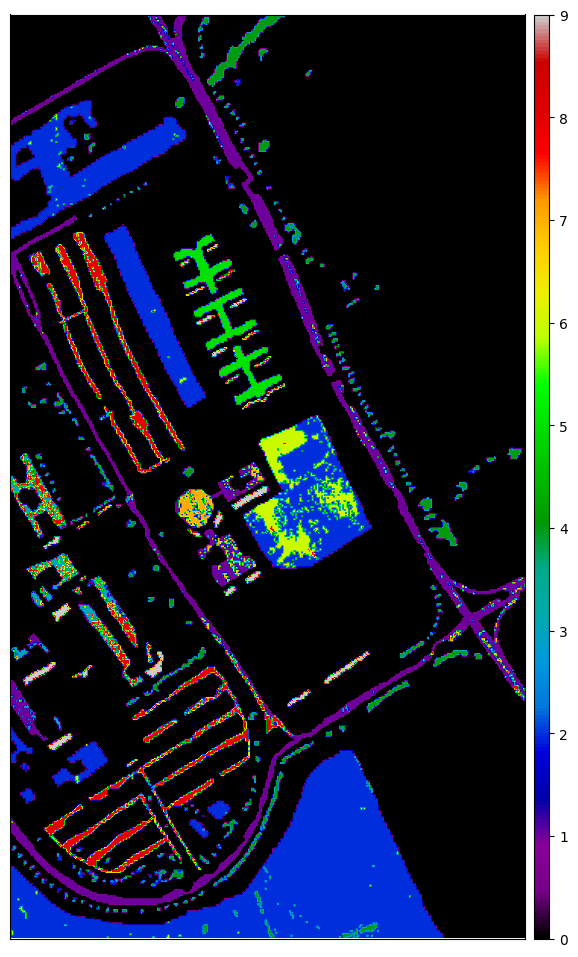

In [18]:
lgb_preds = predict_class(ae_df, clf, name='lgb')

print(accuracy_score(ae_df['class'].values, lgb_preds)*100)
ep.plot_bands(svm_preds.reshape((610, 340)), cmap='nipy_spectral')
plt.show()